In [21]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

from keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

df = pd.read_csv('netflix_reviews.csv')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\c22011387\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\c22011387\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Data processing
df = df.dropna(subset=['userName', 'content'])
df = df.drop(columns=['reviewCreatedVersion', 'appVersion'])

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # 
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    text = text.lower()  # 转为小写
    return text

def is_english(text):
    return re.fullmatch(r'[a-zA-Z\s]*', text) is not None

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return filtered_tokens

df['cleaned_content'] = df['content'].apply(clean_text)
df = df[df['cleaned_content'].apply(is_english)]
df = df[df['cleaned_content'].str.strip() != '']
df['tokens'] = df['cleaned_content'].apply(tokenize_and_remove_stopwords)
df = df[['cleaned_content', 'thumbsUpCount']]
df = df.dropna(subset=['thumbsUpCount'])

In [4]:
# BERT Processing

# Convert the target variable to a classification problem
df['thumbsUpCount'] = df['thumbsUpCount'].apply(lambda x: 1 if x > 0 else 0)

# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Define text vectorization function
def embed_text(texts, tokenizer, model, max_length=256):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embeddings = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
    return cls_embeddings

# Batch processing function
def batch_embed_texts(texts, batch_size=16):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_embeddings = embed_text(batch_texts, tokenizer, model)
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Batching comments into BERT vectors
texts = df['cleaned_content'].tolist()
batch_size = 32  

# Use multithreaded parallel processing
with ThreadPoolExecutor() as executor:
    bert_embeddings = np.vstack(list(executor.map(lambda x: embed_text([x], tokenizer, model), texts)))

# Target variable
y = df['thumbsUpCount']

# Divide into training set and test set
X_train, X_test, y_train, y_test = train_test_split(bert_embeddings, y, test_size=0.2, random_state=42)

C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Overall Accuracy:  71.79%
Logistic Regression Model Report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78     15373
           1       0.54      0.67      0.60      7025

    accuracy                           0.72     22398
   macro avg       0.69      0.70      0.69     22398
weighted avg       0.74      0.72      0.72     22398



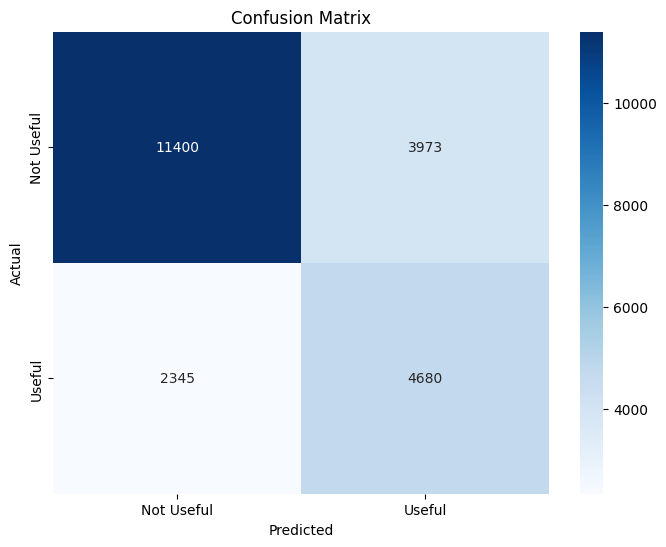

In [6]:
# 1.Logistic Regression Model
model = LogisticRegression(max_iter=200, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


overall_accuracy = accuracy_score(y_test, y_pred) * 100
print("Overall Accuracy:  {:.2f}%".format(overall_accuracy))
print("Logistic Regression Model Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Overall Accuracy (Random Forest):  73.99%
Random Forest Model Report:
              precision    recall  f1-score   support

           0       0.74      0.95      0.83     15373
           1       0.72      0.28      0.41      7025

    accuracy                           0.74     22398
   macro avg       0.73      0.62      0.62     22398
weighted avg       0.73      0.74      0.70     22398



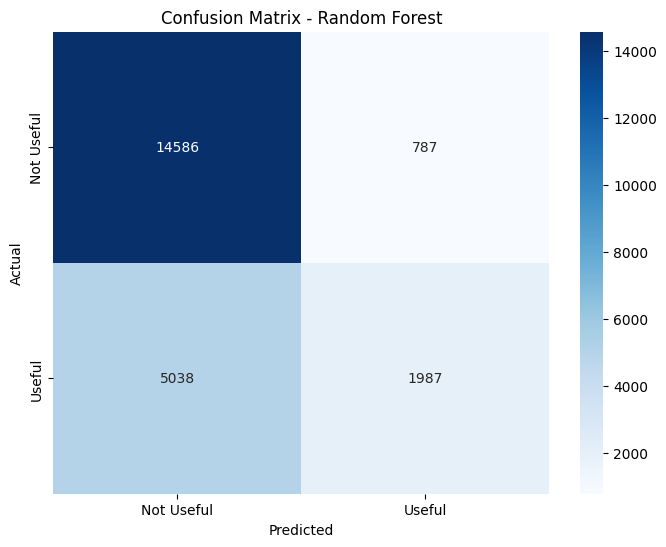

In [7]:
# 2.Random Forest Model 

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

rf_model = RandomForestClassifier(class_weight=class_weights_dict, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

overall_accuracy_rf = accuracy_score(y_test, y_pred_rf) * 100
print("Overall Accuracy (Random Forest):  {:.2f}%".format(overall_accuracy_rf))
print("Random Forest Model Report:")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

Overall Accuracy (XGBoost):  71.05%
XGBoost Model Report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78     15373
           1       0.53      0.59      0.56      7025

    accuracy                           0.71     22398
   macro avg       0.67      0.68      0.67     22398
weighted avg       0.72      0.71      0.71     22398



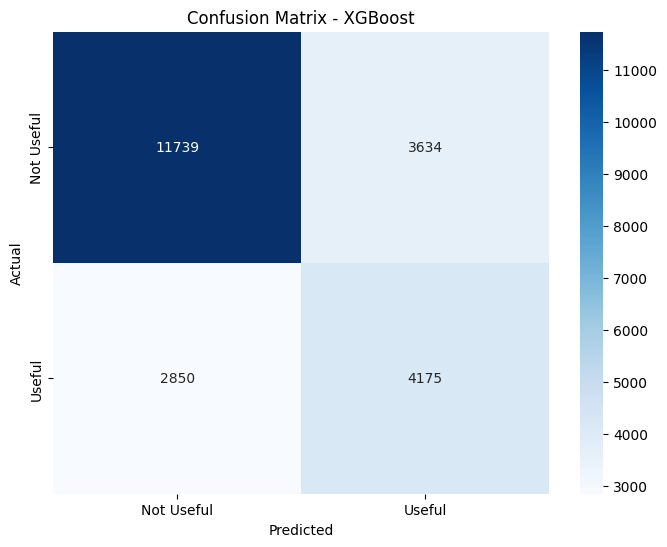

In [8]:
# 3.XGBoost
class_weights = len(y_train) / (2 * np.bincount(y_train))
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

xgb_model = xgb.XGBClassifier(scale_pos_weight=class_weights_dict[1] / class_weights_dict[0], random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

overall_accuracy_xgb = accuracy_score(y_test, y_pred_xgb) * 100
print("Overall Accuracy (XGBoost):  {:.2f}%".format(overall_accuracy_xgb))
print("XGBoost Model Report:")
print(classification_report(y_test, y_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 1577s 561ms/step - accuracy: 0.6875 - loss: 0.6165 - val_accuracy: 0.6897 - val_loss: 0.6007
Epoch 2/5
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 1683s 601ms/step - accuracy: 0.6901 - loss: 0.6019 - val_accuracy: 0.6900 - val_loss: 0.5997
Epoch 3/5
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 1697s 606ms/step - accuracy: 0.6908 - loss: 0.6021 - val_accuracy: 0.6901 - val_loss: 0.5985
Epoch 4/5
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 1708s 610ms/step - accuracy: 0.6895 - loss: 0.6017 - val_accuracy: 0.6900 - val_loss: 0.5991
Epoch 5/5
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 1721s 615ms/step - accuracy: 0.6847 - loss: 0.6105 - val_accuracy: 0.6864 - val_loss: 0.6052
700/700 ━━━━━━━━━━━━━━━━━━━━ 118s 168ms/step
Overall Accuracy (LSTM):  68.64%
LSTM Model Report:
              precision    recall  f1-score   support

           0       0.69      1.00      0.81     15373
           1       0.00      0.00      0.00      7025

    accuracy                           0.69     22398
   macro avg   

C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

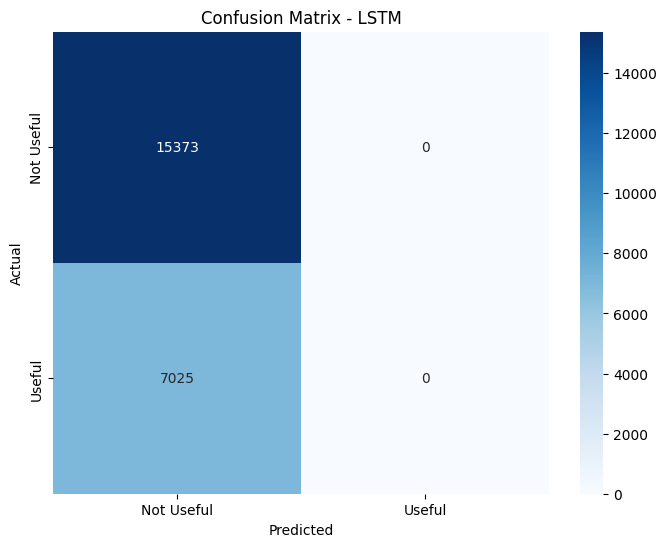

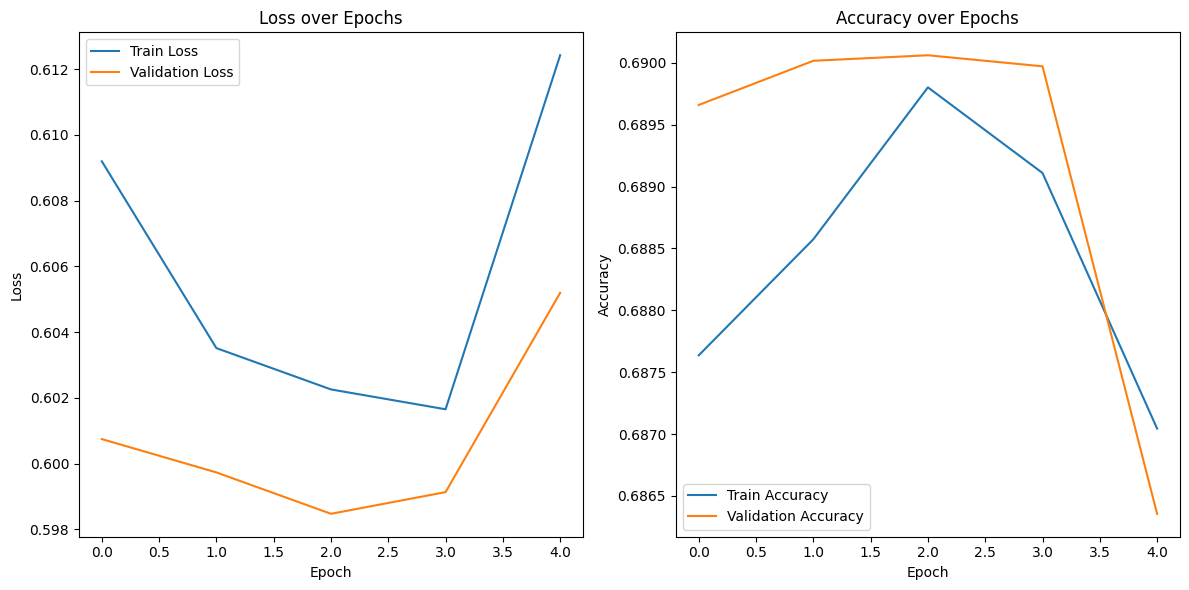

In [5]:
# 4.LSTM Model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=128, input_shape=(bert_embeddings.shape[1],)))
lstm_model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Bidirectional(LSTM(units=32)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(units=1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model
lstm_history = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate LSTM model
y_pred_lstm = (lstm_model.predict(X_test) > 0.5).astype("int32")

# Print overall accuracy
overall_accuracy_lstm = accuracy_score(y_test, y_pred_lstm) * 100
print("Overall Accuracy (LSTM):  {:.2f}%".format(overall_accuracy_lstm))

# Print classification report
print("LSTM Model Report:")
print(classification_report(y_test, y_pred_lstm))

# Confusion matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM')
plt.show()

# Plot LSTM training accuracy and loss
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3850/3850 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.6811 - loss: 0.5975 - val_accuracy: 0.7470 - val_loss: 0.5373
Epoch 2/10
3850/3850 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7055 - loss: 0.5691 - val_accuracy: 0.7002 - val_loss: 0.5908
Epoch 3/10
3850/3850 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7051 - loss: 0.5666 - val_accuracy: 0.7359 - val_loss: 0.5512
Epoch 4/10
3850/3850 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7094 - loss: 0.5630 - val_accuracy: 0.7042 - val_loss: 0.5699
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Overall Accuracy (LSTM):  74.70%
LSTM Model Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82     15373
           1       0.61      0.53      0.57      7025

    accuracy                           0.75     22398
   macro avg       0.70      0.69      0.69     22398
weighted avg       0.74      0.75      0.74     22398



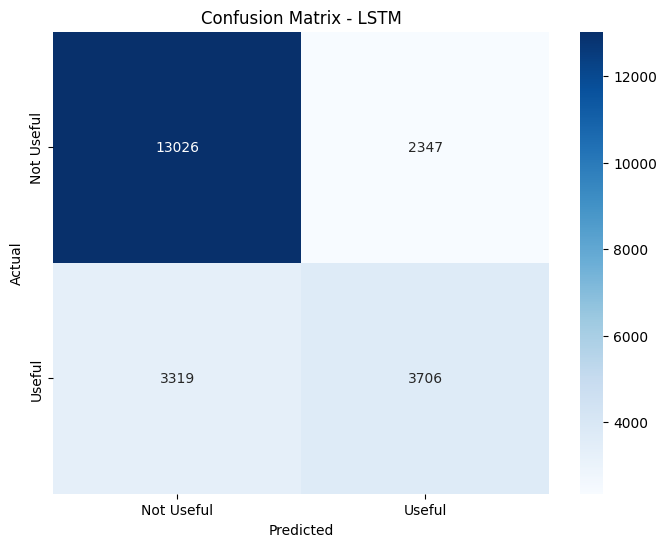

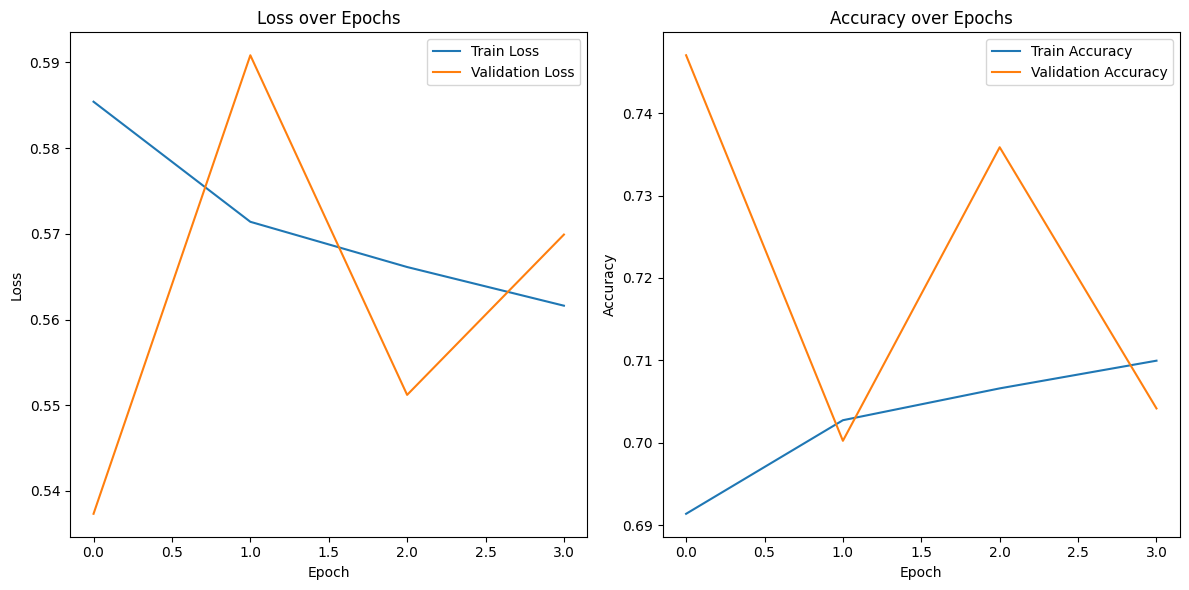

In [13]:
# 5.LSTM+Smote, Class weights

# Use SMOTE to handle imbalanced data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_res), y=y_train_res)
class_weights_dict = dict(enumerate(class_weights))

# Expand dimensions of BERT embeddings to match LSTM input requirements
X_train_res = np.expand_dims(X_train_res, axis=1)  # Shape: (batch_size, 1, embedding_dim)
X_test = np.expand_dims(X_test, axis=1)            # Shape: (batch_size, 1, embedding_dim)


# Create LSTM model
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(units=32, return_sequences=True, input_shape=(X_train_res.shape[1], X_train_res.shape[2]))))
lstm_model.add(Dropout(0.5))
lstm_model.add(Bidirectional(LSTM(units=32)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
lstm_history = lstm_model.fit(X_train_res, y_train_res, epochs=10, batch_size=32, validation_data=(X_test, y_test), 
                              class_weight=class_weights_dict, callbacks=[early_stopping])

# Predict on the test set
y_pred_lstm = (lstm_model.predict(X_test) > 0.5).astype("int32")

# Print overall accuracy
overall_accuracy_lstm = accuracy_score(y_test, y_pred_lstm) * 100
print("Overall Accuracy (LSTM):  {:.2f}%".format(overall_accuracy_lstm))

# Print classification report
print("LSTM Model Report:")
print(classification_report(y_test, y_pred_lstm))

# Confusion matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM')
plt.show()

# Plot LSTM training accuracy and loss
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


Reshaped X_train_res shape: (123192, 1, 768)
X_test shape: (22398, 1, 768)
Testing params: {'dropout_rate': 0.3, 'units': 16}


C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.7460
Testing params: {'dropout_rate': 0.3, 'units': 32}


C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.7379
Testing params: {'dropout_rate': 0.3, 'units': 64}


C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Accuracy: 0.7381
Testing params: {'dropout_rate': 0.5, 'units': 16}


C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.7525
Testing params: {'dropout_rate': 0.5, 'units': 32}


C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.7220
Testing params: {'dropout_rate': 0.5, 'units': 64}


C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Accuracy: 0.7159
Testing params: {'dropout_rate': 0.7, 'units': 16}


C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.7368
Testing params: {'dropout_rate': 0.7, 'units': 32}


C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.7338
Testing params: {'dropout_rate': 0.7, 'units': 64}


C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Accuracy: 0.7419
Best Parameters: {'dropout_rate': 0.5, 'units': 16}
Best Accuracy: 0.7525


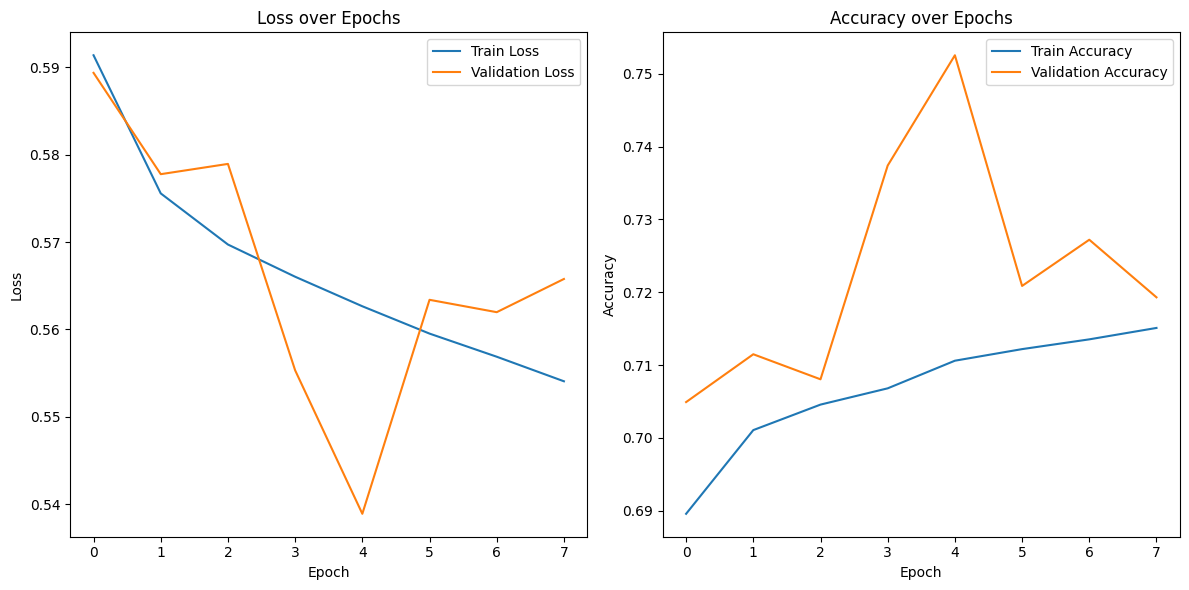

C:\Users\c22011387\OneDrive - Cardiff University\Desktop\Data-analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3850/3850 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.6726 - loss: 0.6046 - val_accuracy: 0.7194 - val_loss: 0.5700
Epoch 2/10
3850/3850 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6995 - loss: 0.5785 - val_accuracy: 0.7449 - val_loss: 0.5474
Epoch 3/10
3850/3850 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7033 - loss: 0.5715 - val_accuracy: 0.7307 - val_loss: 0.5616
Epoch 4/10
3850/3850 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7065 - loss: 0.5675 - val_accuracy: 0.7317 - val_loss: 0.5621
Epoch 5/10
3850/3850 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7082 - loss: 0.5650 - val_accuracy: 0.7197 - val_loss: 0.5694
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Overall Accuracy (Best LSTM):  74.49%
Best LSTM Model Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82     15373
           1       0.60      0.55      0.58      7025

    accuracy                           0.74     22398
   macro avg       0.70 

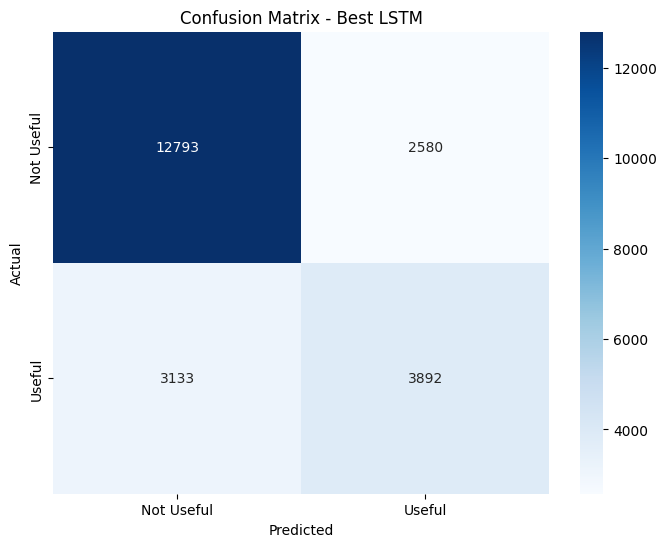

In [24]:
# 6.Use SMOTE to handle imbalanced data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Reshape X_train_res to match the 3D input expected by LSTM
X_train_res = X_train_res.reshape((X_train_res.shape[0], 1, X_train_res.shape[1]))

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_res), y=y_train_res)
class_weights_dict = dict(enumerate(class_weights))

# Print shapes to verify
print("Reshaped X_train_res shape:", X_train_res.shape)
print("X_test shape:", X_test.shape)

# Define the LSTM model creation function
def create_lstm_model(units=32, dropout_rate=0.5):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=units, return_sequences=True, input_shape=(1, 768))))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(units=units)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the parameter grid for GridSearch
param_grid = {
    'units': [16, 32, 64],
    'dropout_rate': [0.3, 0.5, 0.7]
}

# Create a function to train and evaluate the model
def train_and_evaluate(params):
    model = create_lstm_model(units=params['units'], dropout_rate=params['dropout_rate'])
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train_res, y_train_res, epochs=10, batch_size=32, validation_data=(X_test, y_test),
                        class_weight=class_weights_dict, callbacks=[early_stopping], verbose=0)
    
    # Predict on the test set
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, history

# Use GridSearch to find the best parameters
from sklearn.model_selection import ParameterGrid

best_accuracy = 0
best_params = None
best_history = None

for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")
    accuracy, history = train_and_evaluate(params)
    print(f"Accuracy: {accuracy:.4f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_history = history

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# Plot training history of the best model
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Retrain the best model with the best parameters
best_model = create_lstm_model(units=best_params['units'], dropout_rate=best_params['dropout_rate'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
best_model.fit(X_train_res, y_train_res, epochs=10, batch_size=32, validation_data=(X_test, y_test),
               class_weight=class_weights_dict, callbacks=[early_stopping])

# Predict on the test set with the best model
y_pred_best = (best_model.predict(X_test) > 0.5).astype("int32")

# Print overall accuracy
overall_accuracy_best = accuracy_score(y_test, y_pred_best) * 100
print("Overall Accuracy (Best LSTM):  {:.2f}%".format(overall_accuracy_best))

# Print classification report
print("Best LSTM Model Report:")
print(classification_report(y_test, y_pred_best))

# Confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best LSTM')
plt.show()

In [ ]:
# LSTM code Summary
# 4.LSTM Model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=128, input_shape=(bert_embeddings.shape[1],)))
lstm_model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Bidirectional(LSTM(units=32)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(units=1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model
lstm_history = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


# 5.LSTM+Smote, Class weights

# Use SMOTE to handle imbalanced data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_res), y=y_train_res)
class_weights_dict = dict(enumerate(class_weights))

# Expand dimensions of BERT embeddings to match LSTM input requirements
X_train_res = np.expand_dims(X_train_res, axis=1)  # Shape: (batch_size, 1, embedding_dim)
X_test = np.expand_dims(X_test, axis=1)            # Shape: (batch_size, 1, embedding_dim)


# Create LSTM model
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(units=32, return_sequences=True, input_shape=(X_train_res.shape[1], X_train_res.shape[2]))))
lstm_model.add(Dropout(0.5))
lstm_model.add(Bidirectional(LSTM(units=32)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
lstm_history = lstm_model.fit(X_train_res, y_train_res, epochs=10, batch_size=32, validation_data=(X_test, y_test), 
                              class_weight=class_weights_dict, callbacks=[early_stopping])


# 6.Use SMOTE to handle imbalanced data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Reshape X_train_res to match the 3D input expected by LSTM
X_train_res = X_train_res.reshape((X_train_res.shape[0], 1, X_train_res.shape[1]))

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_res), y=y_train_res)
class_weights_dict = dict(enumerate(class_weights))

# Print shapes to verify
print("Reshaped X_train_res shape:", X_train_res.shape)
print("X_test shape:", X_test.shape)

# Define the LSTM model creation function
def create_lstm_model(units=32, dropout_rate=0.5):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=units, return_sequences=True, input_shape=(1, 768))))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(units=units)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the parameter grid for GridSearch
param_grid = {
    'units': [16, 32, 64],
    'dropout_rate': [0.3, 0.5, 0.7]
}

# Create a function to train and evaluate the model
def train_and_evaluate(params):
    model = create_lstm_model(units=params['units'], dropout_rate=params['dropout_rate'])
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train_res, y_train_res, epochs=10, batch_size=32, validation_data=(X_test, y_test),
                        class_weight=class_weights_dict, callbacks=[early_stopping], verbose=0)
    
    # Predict on the test set
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, history

# Use GridSearch to find the best parameters
from sklearn.model_selection import ParameterGrid

best_accuracy = 0
best_params = None
best_history = None

for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")
    accuracy, history = train_and_evaluate(params)
    print(f"Accuracy: {accuracy:.4f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_history = history
    
print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# Plot training history of the best model
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Retrain the best model with the best parameters
best_model = create_lstm_model(units=best_params['units'], dropout_rate=best_params['dropout_rate'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
best_model.fit(X_train_res, y_train_res, epochs=10, batch_size=32, validation_data=(X_test, y_test),
               class_weight=class_weights_dict, callbacks=[early_stopping])

# Predict on the test set with the best model
y_pred_best = (best_model.predict(X_test) > 0.5).astype("int32")

# Print overall accuracy
overall_accuracy_best = accuracy_score(y_test, y_pred_best) * 100
print("Overall Accuracy (Best LSTM):  {:.2f}%".format(overall_accuracy_best))

# Print classification report
print("Best LSTM Model Report:")
print(classification_report(y_test, y_pred_best))

# Confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Useful', 'Useful'], yticklabels=['Not Useful', 'Useful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best LSTM')
plt.show()